# Volatility Smile 

In this notebook, we will create a trading strategy using the volatility smile on the BankNifty call options index. 

### Trading Strategy based on the volatility smile

* A trading strategy based on the volatility smile can be created based on the fact the implied volatility for at the money options will be the lowest and should be strictly increasing as the options go out of the money or in the money for both put and call options.


* So, if there is a point on either side of at the money options in the volatility smile curve, where this condition is violated we can take a trading position till the implied volatilities are back on track and follow the expected smile curve. 


* The strategy would be that everytime we encounter an upward bump/kink in the curve we will take a trading position. Because there would be an unusual increase in the implied volatility and we know that option price is directly proportional to volatility, the option should be overpriced and expecting to go back after this anomaly(the upward bump) goes away to its fair value. 


* The idea is to go long at the upward kink collecting a higher premium and sell when this anomaly goes away and paying a lower premim collecting a profit. 


* Because there is a chance that this anomaly would not go away before expiry, the trading position that we are going to take is a long butterfly spread call to minimize the losses which might be incurred in case the IV does not go back to its normality. 



## Importing libraries 
Importing the relevant libraries for coding the strategy based on volatility smile. Mibian is used to compute the implied volatilities, Pandas is used for taking advantage of its powerful dataframes and matplotlib.pyplot is used to plot the volatility smile, Numpy library will help us with quick vectorized calculations and tabulate library function will be handy when printing the summary of the strategy.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import mibian
import numpy as np
from tabulate import tabulate

## Fetching data  
We fecth data from an excel file that contains call option of BankNifty for dates from Nov-01-2017 to May-21-2018. We store this data in a dataframe df. 

In [2]:
df = pd.read_excel("Data.xlsx")
df.head()

,Symbol,Date,Expiry,Option Type,Strike Price,Open,High,Low,Close,LTP,Settle Price,No. of contracts,Turnover in Lacs,Premium Turnover in Lacs,Open Int,Change in OI,Underlying Value
0,BANKNIFTY,2017-11-01,2017-11-30,CE,22200,3305.0,3309.00,3305.0,3308.45,3308.00,3308.45,58,591.79,76.75,61360,-2320,25490.45
1,BANKNIFTY,2017-11-01,2017-11-30,CE,22300,3150.0,3150.00,3130.0,3130.00,3130.00,3130.00,2,20.35,2.51,29920,40,25490.45
2,BANKNIFTY,2017-11-01,2017-11-30,CE,22400,0.0,0.00,0.0,1757.75,0.00,3206.20,0,0.00,0.00,0,0,25490.45
3,BANKNIFTY,2017-11-01,2017-11-30,CE,22500,2910.0,3034.15,2910.0,3003.50,2995.65,3003.50,13,132.52,15.52,34440,120,25490.45
4,BANKNIFTY,2017-11-01,2017-11-30,CE,22600,0.0,0.00,0.0,2059.05,0.00,3009.95,0,0.00,0.00,0,0,25490.45


# Calculating the implied volatility for all the data entries
For calculating the implied volatility we will use the mibian library function BS and store them on a dataframe column IV and also keep track of Days to expiry. 

In [3]:
df['IV'] = 0  # add a column to the dataframe for Implied Volatility
df['Days_to_expiry'] = 0  # add a column to the dataframe for days to expiry 

for row in range(0, len(df)):
    
    if df['Date'].iloc[row] == df['Expiry'].iloc[row]:
        # When the options are about to expiry is better to set 
        # implied volatilities to zero.
        continue
    
    # Inputs for the Black-scholes-Merton function
    underlyingPrice = df['Underlying Value'].iloc[row]
    strikePrice = df['Strike Price'].iloc[row]
    interestRate = 0 
    days_to_Expiry = ( df['Expiry'].iloc[row] - df['Date'].iloc[row] ).days
    df.iloc[row, df.columns.get_loc('Days_to_expiry') ] = days_to_Expiry
    callPrice = df['Settle Price'].iloc[row]
    
    # Calculate the implied Volatilities and the Greeks.
    result =  mibian.BS( [underlyingPrice, strikePrice, interestRate, days_to_Expiry], 
                       callPrice = callPrice) 
    
    # Set the implied Volatilities for each data entry
    df.iloc[row,df.columns.get_loc('IV') ] = result.impliedVolatility
    

In [4]:
df.tail() # check the dataframe 

,Symbol,Date,Expiry,Option Type,Strike Price,Open,High,Low,Close,LTP,Settle Price,No. of contracts,Turnover in Lacs,Premium Turnover in Lacs,Open Int,Change in OI,Underlying Value,IV,Days_to_expiry
2035,BANKNIFTY,2018-05-31,2018-05-31,CE,27800,0.2,0.2,0.05,0.10,0.10,0.0,249,2768.89,0.01,18000,760,26956.2,0.0,0
2036,BANKNIFTY,2018-05-31,2018-05-31,CE,27900,0.2,0.2,0.05,0.15,0.15,0.0,94,1049.04,0.00,4600,-40,26956.2,0.0,0
2037,BANKNIFTY,2018-05-31,2018-05-31,CE,28000,0.1,0.1,0.05,0.05,0.05,0.0,64,716.80,0.00,25480,1160,26956.2,0.0,0
2038,BANKNIFTY,2018-05-31,2018-05-31,CE,28100,0.1,0.1,0.05,0.05,0.05,0.0,318,3574.33,0.01,800,-120,26956.2,0.0,0
2039,BANKNIFTY,2018-05-31,2018-05-31,CE,28200,1.0,1.0,1.00,1.00,1.00,0.0,1,11.28,0.00,40,40,26956.2,0.0,0


## Function for plotting the volatility smile curve

In [5]:
def plot_volatility_smile(df, date):
    """
    Takes in as input dataframe object df and a timestamp date
    and plots the volatility smile curve for that date.
    """
    option_data = df[ df['Date'] == date ]   
    plt.plot( option_data['Strike Price'], option_data['IV'] )
    plt.xlabel("Strike Price")
    plt.ylabel("IV")
    plt.grid(True)
    plt.legend( option_data['Date'])
    plt.title("Volatility Smile")
    plt.show()

## Plotting all volatility smile curve for each date
Here can see the bumps/kinks

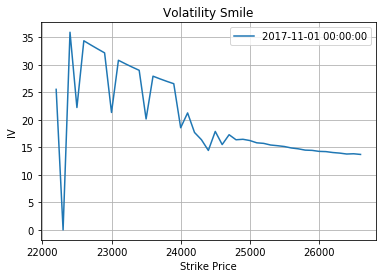

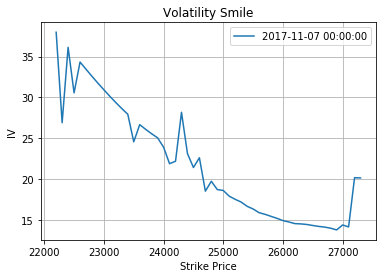

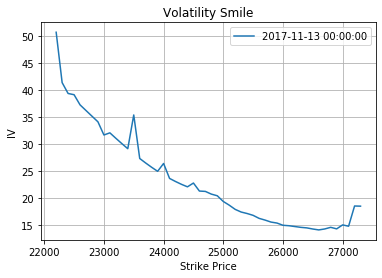

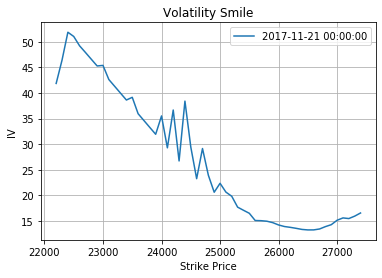

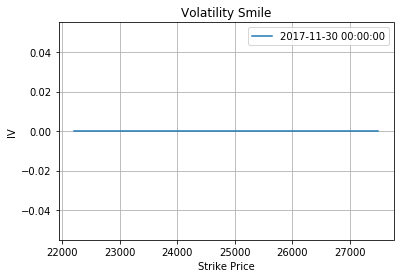

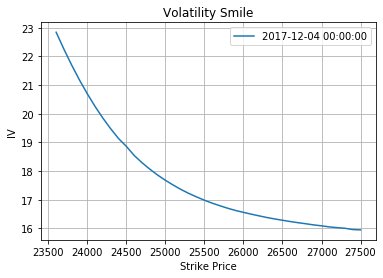

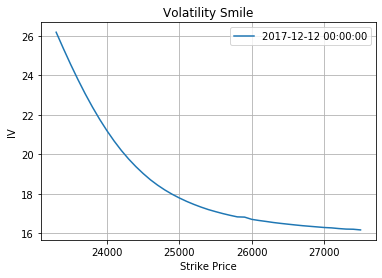

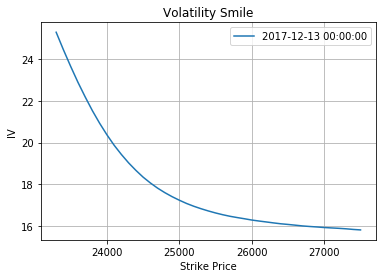

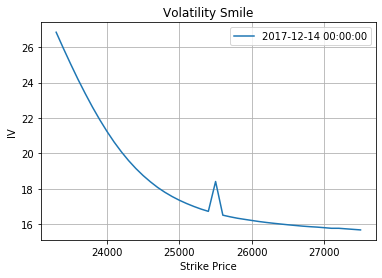

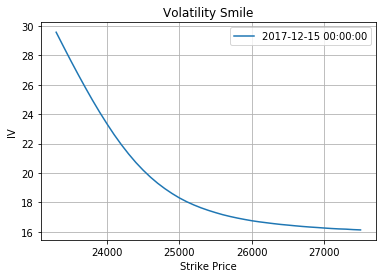

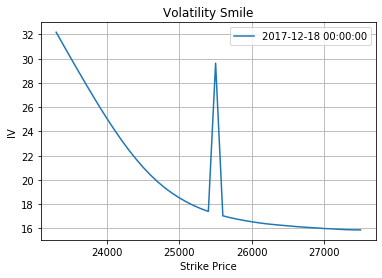

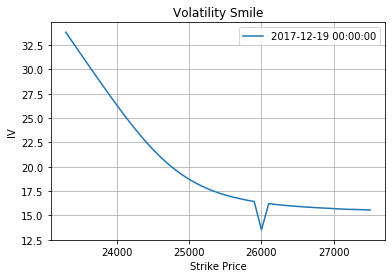

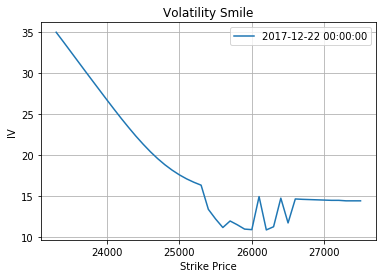

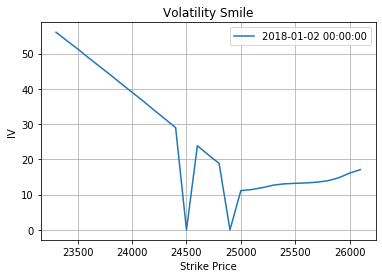

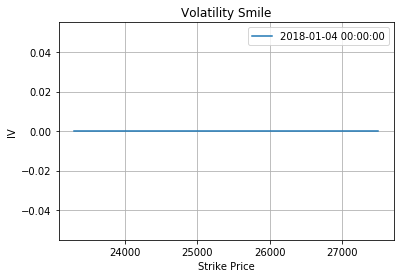

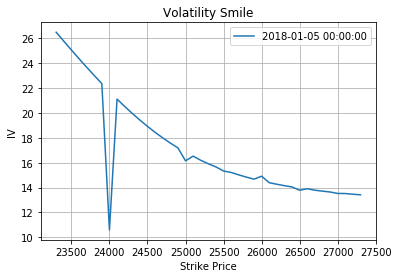

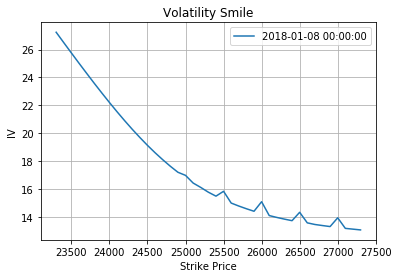

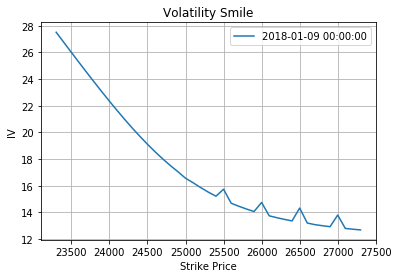

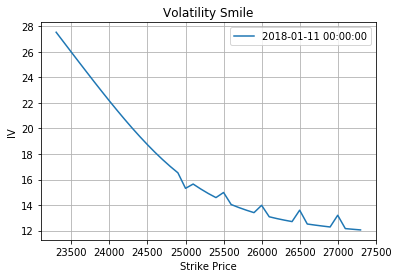

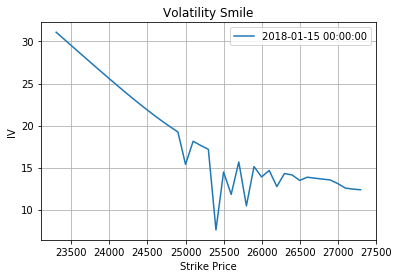

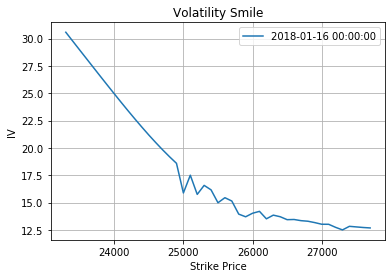

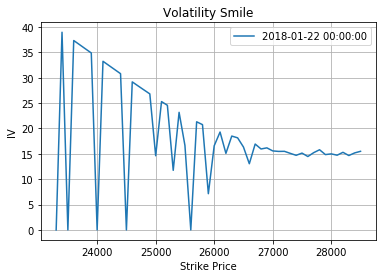

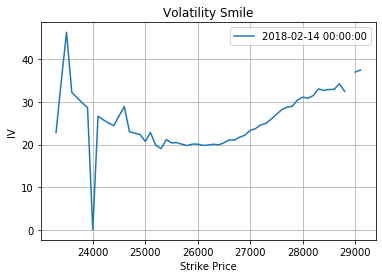

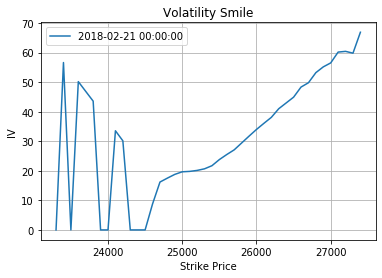

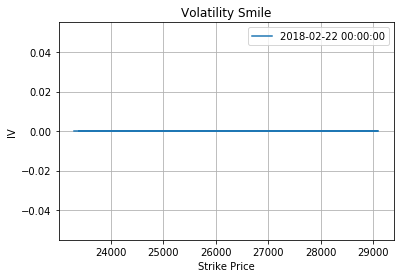

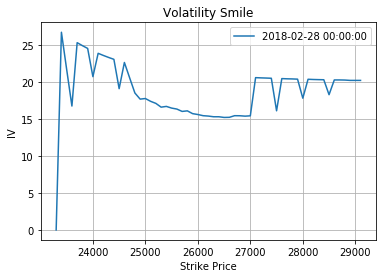

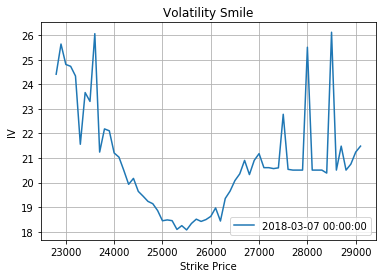

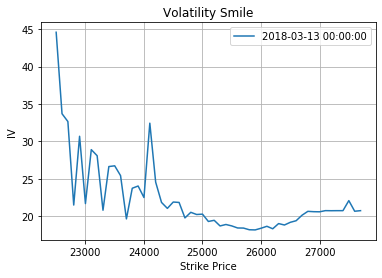

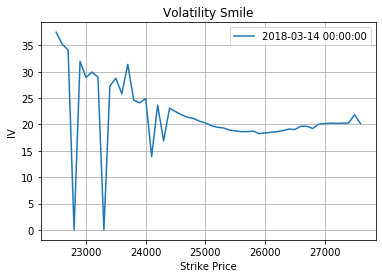

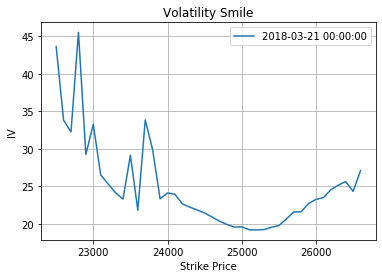

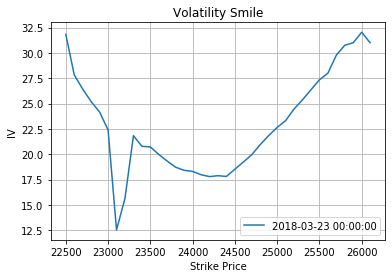

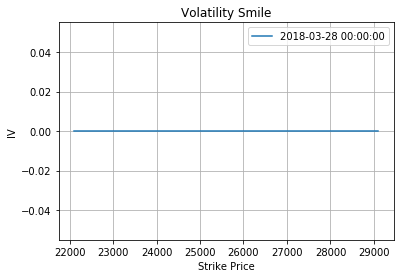

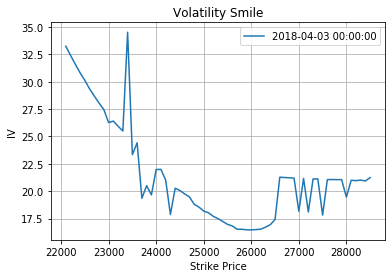

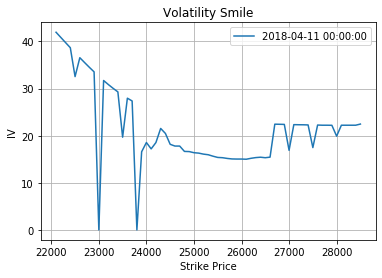

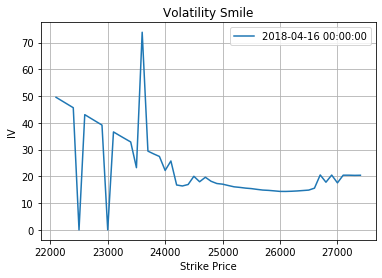

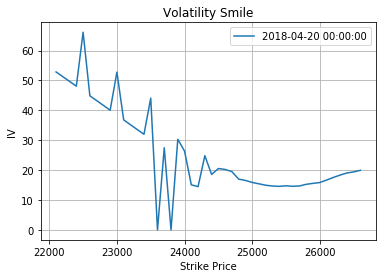

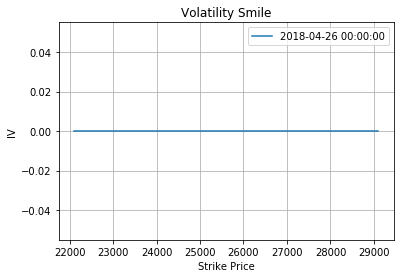

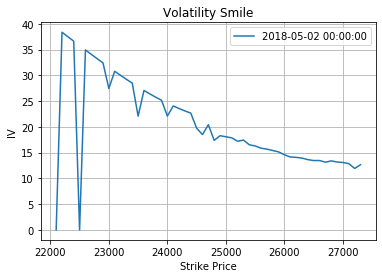

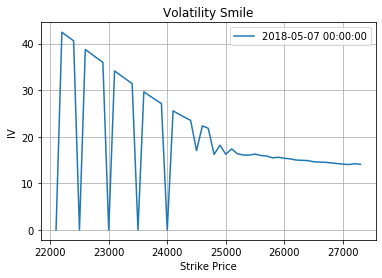

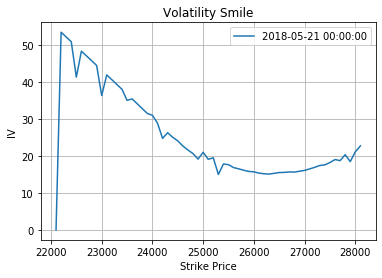

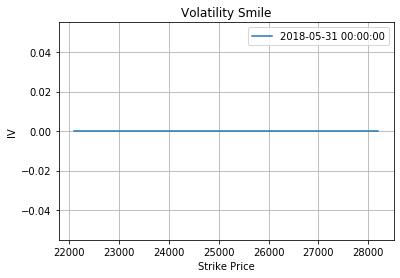

In [6]:
date_list = list( set(df['Date'] ) )
date_list.sort()

for date in date_list:
    plot_volatility_smile(df,date)

## Payoff of long butterfly spread
This function will be called in the case we do not close our open position and we will either receive the max profit or at least a profit or accept the limited loss. 

In [7]:
def payoff_long_butterfly_spread(middle_call_price, middle_call_premium, 
                                 higher_strike_call_price, higher_call_premium,
                                 lower_strike_call_price, lower_call_premium, underlying_at_expiry):
    '''
    Takes as input:    a floating number        middle_call_price 
                       a floating number        middle_call_premium
                       a floating number        higher_strike_call_price 
                       a floating number        higher_call_premium
                       a floating number        lower_strike_call_price
                       a floating number        lower_call_premium
                       a floating number        underlying_at_expiry 
    returns the payoff of long butterfly spread 
    '''
                                #               Long Butterfly Spread
                                # We sold 2 calls at middle_call_price
                                # Bought 1 call at a higher strike price 
                                # Bought 1 call at a lower strike price
    print( f"\n\nMiddle Call price = {middle_call_price}\t\tPremium received = {middle_call_premium}"   )
    print( f"Higher Strike Call price = {higher_strike_call_price}\t\tPremium paid = {higher_call_premium}"   )
    print( f"Lower Strike Call price = {lower_strike_call_price}\t\tPremium paid = {lower_call_premium}"   )
    print( f"Underlying price at Expiry: {underlying_at_expiry} "  )
    
    pay_off_1 = max( underlying_at_expiry - middle_call_price , 0)
    pay_off_2 = max( underlying_at_expiry - lower_strike_call_price, 0 )
    pay_off_3 = max( underlying_at_expiry - higher_strike_call_price, 0 )
    
    
    return  ( 2*(middle_call_premium - pay_off_1 ) + (pay_off_3 - higher_call_premium) + (pay_off_2 - lower_call_premium) )
    
    

## Starting the trading strategy by checking the bumps in the volatility smile curve

* Everytime we see a significant upward bump, we take a trading position ( long butterfly spread) and whenever the bump/kink goes away, we close our position. Expecting to receive a higher premium on the long position(because we are selling two calls at the kink which is the anomaly) and paid a lower premium whenever we close it. 

*  We included the Transaction cost brokerage by following the rules of( https://zerodha.com/charges#tab-equities ):
                           1) I have to pay a 0.053% on the premium received
                           2) 20 INR per executed order. 


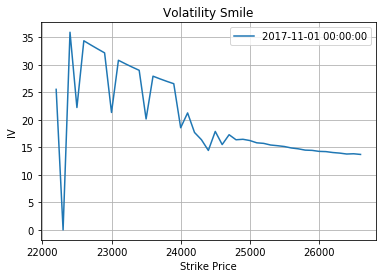

Position opened 
Date: 2017-11-01 00:00:00 
Strike Price: 22400 
 Money Received: INR 6330.700714


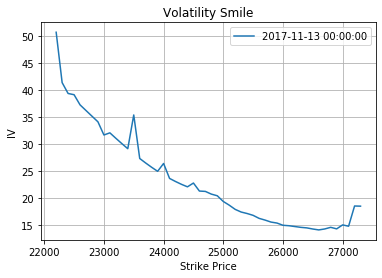

Position closed 
Date: 2017-11-13 00:00:00 
Strike Price: 22400 
 Money Paid: INR 6130.3118


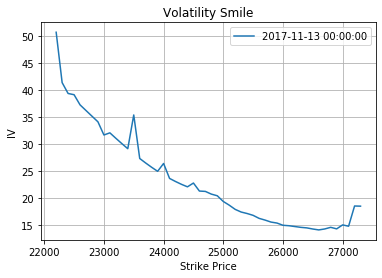

Position opened 
Date: 2017-11-13 00:00:00 
Strike Price: 23500 
 Money Received: INR 3948.93205


Middle Call price = 23500		Premium received = 2015.0
Higher Strike Call price = 23600		Premium paid = 1836.4
Lower Strike Call price = 23400		Premium paid = 2031.55
Underlying price at Expiry: 25332.4 


Payoff Long Butterfly Spread: 162.04999999999995
Long Buttlerfly Spread Call has been executed.


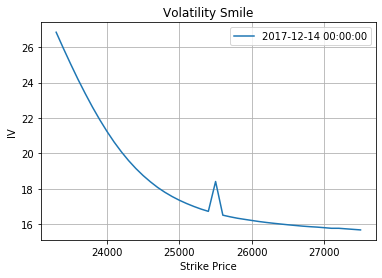

Position opened 
Date: 2017-12-14 00:00:00 
Strike Price: 25500 
 Money Received: INR 519.841


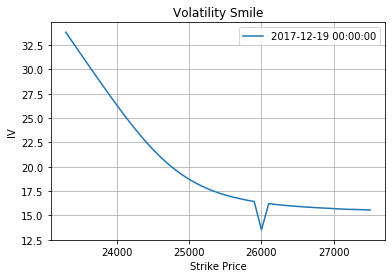

Position closed 
Date: 2017-12-19 00:00:00 
Strike Price: 25500 
 Money Paid: INR 1048.415478


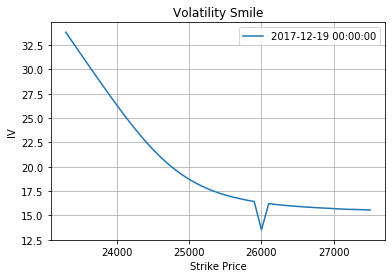

Position opened 
Date: 2017-12-19 00:00:00 
Strike Price: 25900 
 Money Received: INR 459.45700600000004


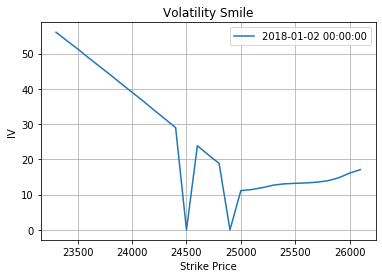

Position closed 
Date: 2018-01-02 00:00:00 
Strike Price: 25900 
 Money Paid: INR 84.60312699999999


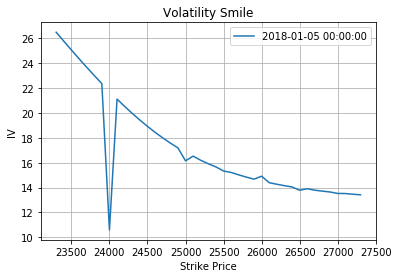

Position opened 
Date: 2018-01-05 00:00:00 
Strike Price: 24100 
 Money Received: INR 3388.2806619999997


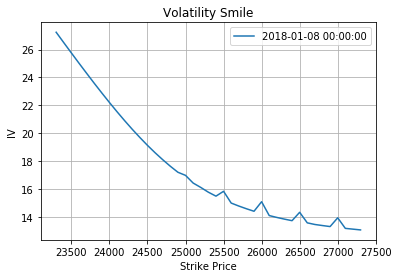

Position closed 
Date: 2018-01-08 00:00:00 
Strike Price: 24100 
 Money Paid: INR 3657.0953594999996


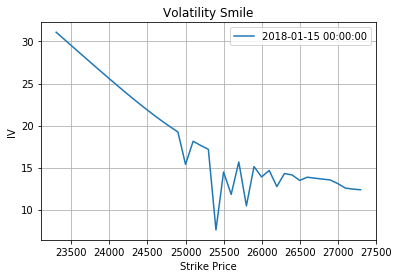

Position opened 
Date: 2018-01-15 00:00:00 
Strike Price: 25100 
 Money Received: INR 2324.4626485


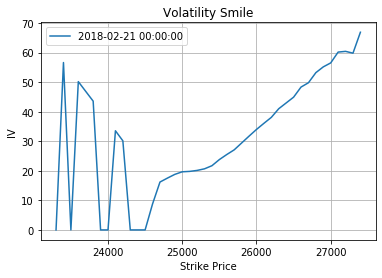

Position closed 
Date: 2018-02-21 00:00:00 
Strike Price: 25100 
 Money Paid: INR 163.4509595


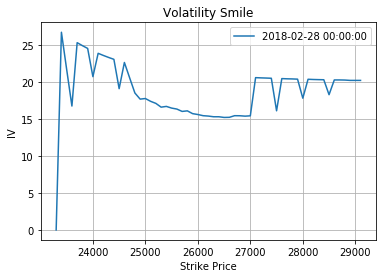

Position opened 
Date: 2018-02-28 00:00:00 
Strike Price: 23400 
 Money Received: INR 3663.5077075


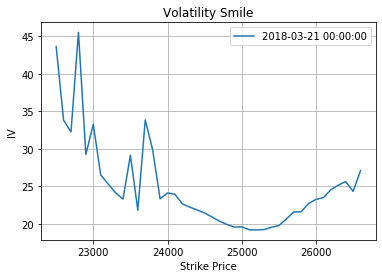

Position closed 
Date: 2018-03-21 00:00:00 
Strike Price: 23400 
 Money Paid: INR 1894.893538


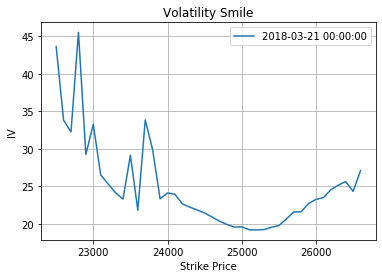

Position opened 
Date: 2018-03-21 00:00:00 
Strike Price: 23500 
 Money Received: INR 1668.736462


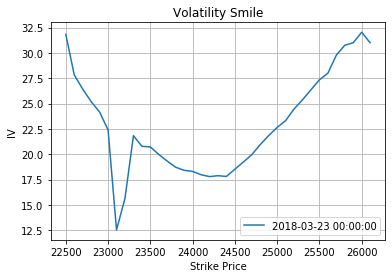

Position closed 
Date: 2018-03-23 00:00:00 
Strike Price: 23500 
 Money Paid: INR 727.14238


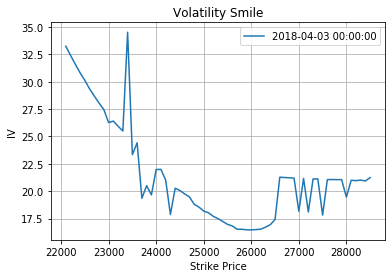

Position opened 
Date: 2018-04-03 00:00:00 
Strike Price: 23400 
 Money Received: INR 2917.20553


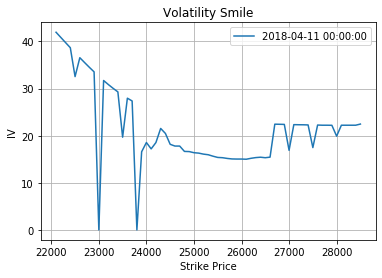

Position closed 
Date: 2018-04-11 00:00:00 
Strike Price: 23400 
 Money Paid: INR 3646.5526944999997


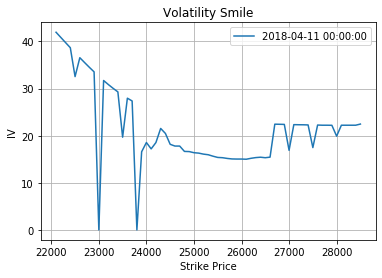

Position opened 
Date: 2018-04-11 00:00:00 
Strike Price: 23600 
 Money Received: INR 3110.0544115000002


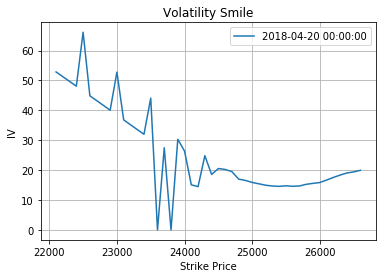

Position closed 
Date: 2018-04-20 00:00:00 
Strike Price: 23600 
 Money Paid: INR 2661.493646


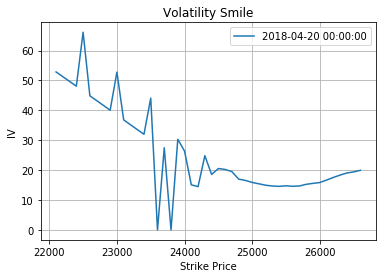

Position opened 
Date: 2018-04-20 00:00:00 
Strike Price: 23700 
 Money Received: INR 2463.0259195


Middle Call price = 23700		Premium received = 1271.85
Higher Strike Call price = 23800		Premium paid = 1110.0
Lower Strike Call price = 23600		Premium paid = 1290.0
Underlying price at Expiry: 25010.9 


Payoff Long Butterfly Spread: 143.69999999999982
Long Buttlerfly Spread Call has been executed.


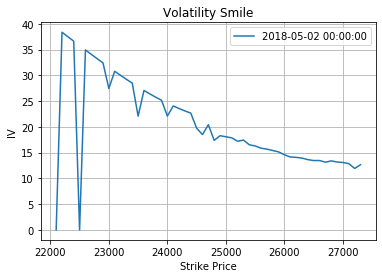

Position opened 
Date: 2018-05-02 00:00:00 
Strike Price: 22200 
 Money Received: INR 6886.15348


Middle Call price = 22200		Premium received = 3484.0
Higher Strike Call price = 22300		Premium paid = 3384.65
Lower Strike Call price = 22100		Premium paid = 3450.0
Underlying price at Expiry: 26956.2 


Payoff Long Butterfly Spread: 133.3499999999999
Long Buttlerfly Spread Call has been executed.


In [8]:
df['Signal'] = 0  # add a dataframe column to keep track of the trading signals
df['PNL'] = 0    # add a dataframe column to keep track of the PNL
df['MTM'] = 0   # add a datafrane column to keep track of the MTM
df['Number of trades'] = 0 # add a dataframe columns to keep track of the number of trades

transaction_cost_brokerage = 20 # transaction cost per executed order

# identifying the bumps in the volatility smile
for row in range(1, len(df) -1): 
    
    # We will be opening a trading position if there is no open position(which means our signal is cero).  
    if df.iloc[row]['Signal'] == 0:
        
        # check if the call option is in the money(ITM) or out of the money (OTM)
        ITM_check = df.iloc[row]['Underlying Value'] > df['Strike Price'].iloc[row] 
        OTM_check = df['Underlying Value'].iloc[row] < df['Strike Price'].iloc[row]
        
        # check if current date and the next date row are the same
        same_day_check_ahead = df['Date'].iloc[row] == df['Date'].iloc[row+1]
        # check if te current date and the previous date row are the same
        same_day_check_behind = df['Date'].iloc[row] == df['Date'].iloc[row-1]
        
    # The first check is for in the money options and ensuring that the previous row data is of the same date 
        if ITM_check and same_day_check_behind:        
            
            # checking for a significant kink
            if df['IV'].iloc[row] > ( df['IV'].iloc[row - 1] + 1.5 ): 
                # we are in a long position so put the current signal to 1. 
                df.iloc[row, df.columns.get_loc('Signal') ] = 1 
                
                # We did a trade so place a 1 in current trade
                df.iloc[row, df.columns.get_loc('Number of trades') ] = 1
                
                # Setting PNL to the cost of buying the butterfly spread, by writing two call options at 
                # the Strike of current row and buying call options at the strikes on rows ahead and behind
                # the current row.
                long_butterfly_spread_premium =  2*df['Settle Price'].iloc[row] 
                - df['Settle Price'].iloc[row + 1] - df['Settle Price'].iloc[row - 1] 
            
                # We include the transaction costs
                transaction_costs = -transaction_cost_brokerage*4 - (0.053/100)*df['Settle Price'].iloc[row]
                
                df.iloc[row, df.columns.get_loc('PNL')] = long_butterfly_spread_premium + transaction_costs
                
                # Keep track on where(what row) did we place the trading position, this variable will be used later
                # to match strike price, while closing the open buy position.  
                Open_position = row 
                
                # Print the volatility smile
                plot_volatility_smile(df, df['Date'].iloc[row] ) 
                
                # Print the output of the open position
                if df['PNL'].iloc[row] > 0 : 
                    PnL = [ "Money Received: INR", df['PNL'].iloc[row] ]  
                elif df['PNL'].iloc[row] < 0 : 
                    PnL = [ "Moeny Paid: INR", -df['PNL'].iloc[row] ]
                
                print( "Position opened", "\nDate:", df['Date'].iloc[row], "\nStrike Price:",  
                     df['Strike Price'].iloc[row], '\n', PnL[0], PnL[1] )
                
        # the second check is for out of the money options and ensuring that the next row data is of the same date.
        elif OTM_check and same_day_check_ahead: 
            # checking for a significant kink
            if df['IV'].iloc[row] >  (df['IV'].iloc[row+1] + 1.5 ):
                # we take a long position so put the current signal to 1. 
                df.iloc[row, df.columns.get_loc('Signal') ] = 1  
                
                # We did a trade so place a 1 in current trade
                df.iloc[row, df.columns.get_loc('Number of trades') ] = 1
                
                # Setting PNL to the cost of buying the butterfly spread, by writing two call options at 
                # the Strike of current row and buying call options at the strikes on rows ahead and behind
                # the current row.
                long_butterfly_spread_premium = 2*df['Settle Price'].iloc[row]  
                -df['Settle Price'].iloc[row - 1] - df['Settle Price'].iloc[row + 1 ]
                
                # We included the transaction cost 
                transaction_costs = -transaction_cost_brokerage*4 - (0.053/100)*df['Settle Price'].iloc[row]
                
                df.iloc[row, df.columns.get_loc('PNL') ] = long_butterfly_spread_premium + transaction_costs
                
                # Keep track on where(what row) did we place the trading position, this variable will be used later
                # to match strike price, while closing the open buy position. 
                Open_position = row  
                
                # Print the volatility smile
                plot_volatility_smile( df, df['Date'].iloc[row] ) 
                
                # Printing the output of the open position
                if df['PNL'].iloc[row] > 0 :
                    PnL = [ "Money Received: INR", df['PNL'].iloc[row]  ]
                elif df['PNL'].iloc[row] < 0 :
                    PnL = [ "Money Paid: INR", -df['PNL'].iloc[row] ]
                
                print( "Position opened", "\nDate:", df['Date'].iloc[row], "\nStrike Price:", 
                     df['Strike Price'].iloc[row], '\n', PnL[0], PnL[1] ) 
                
    # Closing positions by selling the spread
    # We will now generate a sell signal by observing the smile curve regain its original expected shape, 
    # i.e. once the bump is removed.
    elif df['Signal'].iloc[row] == 1 and df['Strike Price'].iloc[row] == df['Strike Price'].iloc[Open_position]:
        
        # checking whether the Option is in the money
        if df['Underlying Value'].iloc[row] > df['Strike Price'].iloc[row]:
           
            # check if the bump is gone 
            if df['IV'].iloc[row] < df['IV'].iloc[row-1]: 
                # We need to close our open position, so set signal back to 0 
                df.iloc[row, df.columns.get_loc('Signal') ] = 0 
                
                # We did a trade so place a 1 in current trade
                df.iloc[row, df.columns.get_loc('Number of trades') ] = 1
                
                # setting the PNL by selling the butterfly spread
                short_butterfly_spread_premium = -2*df['Settle Price'].iloc[row]  
                +df['Settle Price'].iloc[row+1] +df['Settle Price'].iloc[row -1] 
                
                # We included the transaction costs   
                transaction_costs = -transaction_cost_brokerage*4 -(0.053/100)*df['Settle Price'].iloc[row +1] -(0.053/100)*df['Settle Price'].iloc[row-1]
                
                df.iloc[ row, df.columns.get_loc('PNL') ] = short_butterfly_spread_premium + transaction_costs 
                
                # Plot the smile 
                plot_volatility_smile( df, df['Date'].iloc[row] )
                
                # Printing the output of selling a butterfly spread 
                if df['PNL'].iloc[row] > 0:
                    PnL = [ "Money Received: INR", df['PNL'].iloc[row] ]
                elif df['PNL'].iloc[row] < 0:
                    PnL = [ "Money Paid: INR", -df['PNL'].iloc[row] ]
                    
                print( "Position closed", "\nDate:", df['Date'].iloc[row], "\nStrike Price:", 
                       df['Strike Price'].iloc[row], "\n", PnL[0], PnL[1] )
                print( "="*50 )
                    
        # checking whether the Option is out of the money
        elif df['Underlying Value'].iloc[row] < df['Strike Price'].iloc[row]:
            # check if the bump is gone 
            if df['IV'].iloc[row] < df['IV'].iloc[row+1]: 
                
                # We need to close our open position, so set signal back to 0 
                df.iloc[row, df.columns.get_loc('Signal') ] = 0 
                
                # We did a trade so place a 1 in current trade
                df.iloc[row, df.columns.get_loc('Number of trades') ] = 1
                
                # Setting the PNL by selling the spread 
                short_butterfly_spread_premium = -2*df['Settle Price'].iloc[row]  
                + df['Settle Price'].iloc[row - 1] + df['Settle Price'].iloc[row + 1 ]
                 
                # We included the transaction costs
                transaction_costs = -transaction_cost_brokerage*4 -(0.053/100)*df['Settle Price'].iloc[row +1] -(0.053/100)*df['Settle Price'].iloc[row-1]
                
                df.iloc[row, df.columns.get_loc('PNL') ] = short_butterfly_spread_premium + transaction_costs
                
                # Plot the volatility smile 
                plot_volatility_smile( df, df['Date'].iloc[row] ) 
                
                # Printing the output of selling a butterfly spread 
                if df['PNL'].iloc[row] > 0:
                    PnL = [ "Money Received: INR", df['PNL'].iloc[row] ] 
                elif df['PNL'].iloc[row] < 0:
                    PnL = [ "Money Paid: INR", -df['PNL'].iloc[row] ]
                
                print( "Position closed", "\nDate:", df['Date'].iloc[row], "\nStrike Price:",  
                     df['Strike Price'].iloc[row], "\n", PnL[0], PnL[1] )
                print( "="*50 )
        
                                          # Computing MTM of trades
        # Here, we compute the MTM of trades, MTM is the mark to market value and it represents the value 
        # of the assets that we have purchased. 
        df.iloc[ row, df.columns.get_loc('MTM') ] = 2*df['Settle Price'].iloc[row]  
        -df['Settle Price'].iloc[row + 1] - df['Settle Price'].iloc[row - 1]
    
    # if the current value of the signal is one and the bump is still there
    # we set the next signal value to one because we are still on the long position
    if df['Signal'].iloc[row] == 1:
        df.iloc[row+1, df.columns.get_loc('Signal') ] = 1     
        
        # In the case we are at Expiry and still have a long position, we need take into account
        # the long Butterfly Spread payoff
        if df['Date'].iloc[row] == df['Expiry'].iloc[row] and (row+1 == len(df)-1 or df['Date'].iloc[row+1] != df['Date'].iloc[row]):
            middle_strike = df['Strike Price'].iloc[Open_position]
            middle_premium = df['Settle Price'].iloc[Open_position]
            
            higher_strike = df['Strike Price'].iloc[Open_position + 1] 
            higher_premium = df['Settle Price'].iloc[Open_position +1 ]
            
            lower_strike = df['Strike Price'].iloc[Open_position -1]
            lower_premium = df['Settle Price'].iloc[Open_position -1]
            
            underlying = df['Underlying Value'].iloc[row]
            
            pay_off_long_butterfly_spread = payoff_long_butterfly_spread(middle_strike, middle_premium, 
                                                                        higher_strike, higher_premium, 
                                                                        lower_strike, lower_premium, 
                                                                        underlying) 
            
            print( f"\n\nPayoff Long Butterfly Spread: {pay_off_long_butterfly_spread}" )
            print( "Long Buttlerfly Spread Call has been executed." )
            print( "="*50 )
            
            df.iloc[row+1, df.columns.get_loc('PNL')] = pay_off_long_butterfly_spread
            df.iloc[row+1, df.columns.get_loc('Signal') ] = 0
        

## Analysing Model Output

#### Computing cumulative PNL
Here, we compute the cumulative PNL by buying and selling the butterfly spread and taking in cosideration the long butterfly payoff in the cases we did not close the open position. We make use of the cumsum function.

In [9]:
df['Cumulative PNL'] = df['PNL'].cumsum()

print( "\n\nCumulative PNL from the volatility smile trading strategy: INR", df['Cumulative PNL'].iloc[-1]   )



Cumulative PNL from the volatility smile trading strategy: INR 18105.498608500002


#### Plot the Cumulative PNL

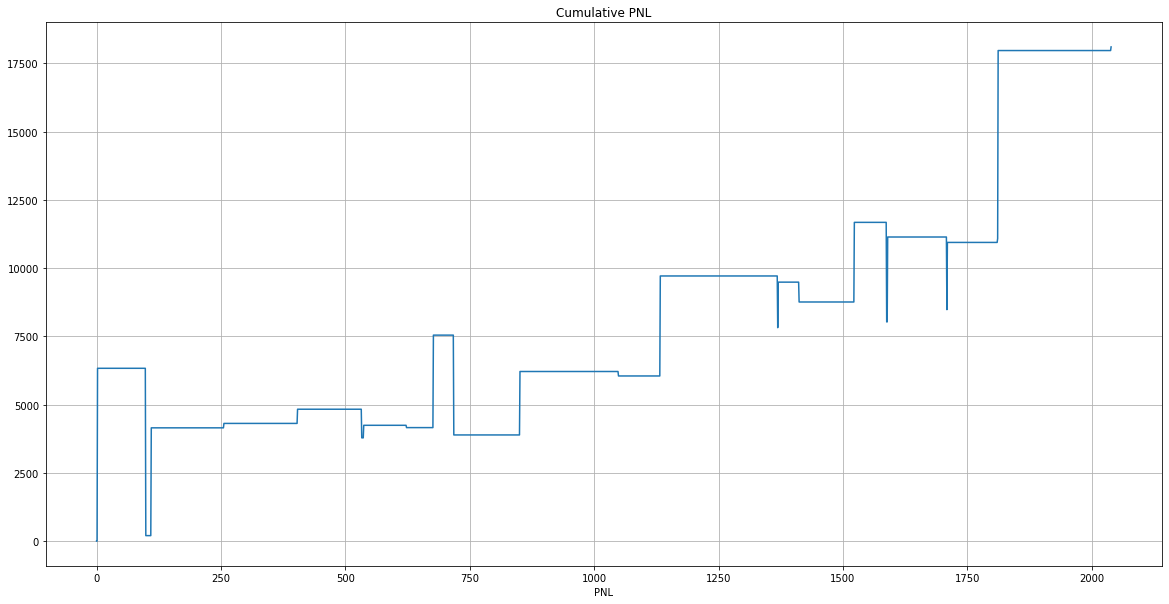

In [10]:
df['Cumulative PNL'].plot( figsize =(20,10), grid = True, title = "Cumulative PNL")
plt.xlabel( "PNL" )
plt.show()

#### Calculate the number of trades, positive trades, negative trades, Hit Ratio, Sharpe Ratio of the strategy

In [11]:
# Calculate the number of trades
df['Number of trades'] = df['Number of trades'].cumsum() 

In [12]:
# Calculate the number of positives trades
df['Number of positive trades'] = np.where( (df['PNL'] > 0) & (df['Signal'] != 0) , 1, 0 ).cumsum()

# Calculate the number of negatives trades
df['Number of negative trades'] = np.where(  (df['PNL'] < 0) ,   1, 0).cumsum()

total_trades = df['Number of positive trades'].iloc[-1] + df['Number of negative trades'].iloc[-1] 

# Calculate the Hit Ratio
df['Hit Ratio'] = df['Number of positive trades'].iloc[-1]/total_trades

# Calculate the Sharpe Ratio
df['Sharpe Ratio'] = df['PNL'].mean()/df['PNL'].std()

In [13]:
df.tail() # check the updated dataframe

,Symbol,Date,Expiry,Option Type,Strike Price,Open,High,Low,Close,LTP,...,Days_to_expiry,Signal,PNL,MTM,Number of trades,Cumulative PNL,Number of positive trades,Number of negative trades,Hit Ratio,Sharpe Ratio
2035,BANKNIFTY,2018-05-31,2018-05-31,CE,27800,0.2,0.2,0.05,0.10,0.10,...,0,1,0.00,0.0,21,17972.148609,12,9,0.571429,0.02601
2036,BANKNIFTY,2018-05-31,2018-05-31,CE,27900,0.2,0.2,0.05,0.15,0.15,...,0,1,0.00,0.0,21,17972.148609,12,9,0.571429,0.02601
2037,BANKNIFTY,2018-05-31,2018-05-31,CE,28000,0.1,0.1,0.05,0.05,0.05,...,0,1,0.00,0.0,21,17972.148609,12,9,0.571429,0.02601
2038,BANKNIFTY,2018-05-31,2018-05-31,CE,28100,0.1,0.1,0.05,0.05,0.05,...,0,1,0.00,0.0,21,17972.148609,12,9,0.571429,0.02601
2039,BANKNIFTY,2018-05-31,2018-05-31,CE,28200,1.0,1.0,1.00,1.00,1.00,...,0,0,133.35,0.0,21,18105.498609,12,9,0.571429,0.02601


##### Calculating the drawdowns, max drawdown, and plotting the drawdowns of the strategy

In [14]:
def cal_drawdown(cum_returns):
    '''
    Function that calculates the drawdowns of the strategy
    Takes as input series cum_returns 
    and it returns a series drawdown.   
    '''
    running_max = np.maximum.accumulate( cum_returns.dropna() )
    running_max[running_max < 1] = 1 
    drawdown = (cum_returns)/running_max -1
    return drawdown 

In [15]:
drawdown = cal_drawdown( df['Cumulative PNL'])
df['Drawdown'] = drawdown 
print( f"Max Drawdown of the strategy is {drawdown.min()*100 } % " )

Max Drawdown of the strategy is -100.0 % 


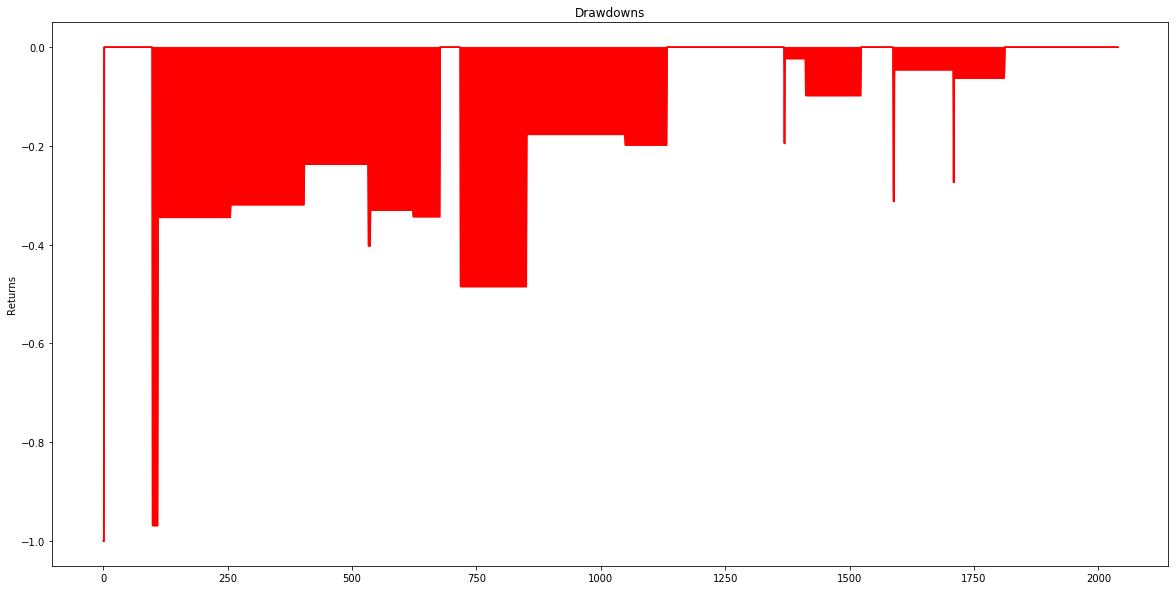

In [16]:
drawdown.plot( figsize = (20,10), color = 'r')

plt.ylabel("Returns")
plt.title( "Drawdowns" )
plt.fill_between(drawdown.index, drawdown, color = 'red')
plt.show()

####  Printing the Summary Results of the volatility smile trading strategy

In [24]:
# Store the Summary result in a nested list
Summary = [ ["Number of Trades", df['Number of trades'].iloc[-1] ], 
            ["Number of Positive Trades", df['Number of positive trades'].iloc[-1] ], 
            ["Number of Negative Trades", df['Number of negative trades'].iloc[-1] ], 
            ["Hit Ratio", round( df['Hit Ratio'].iloc[-1], 5) ] , 
            ["Sharpe Ratio", round( df['Sharpe Ratio'].iloc[-1], 5) ], 
            ["Max Drawdown", str( df['Drawdown'].min()*100) + " %"  ]
          ]

# Print the results in a nice table
print("\t\t    Summary")
print("_____________________________________________")
print(tabulate(Summary ,
        headers=['Trading Parameters','Value'],tablefmt='orgtbl'))

		    Summary
_____________________________________________
| Trading Parameters        | Value    |
|---------------------------+----------|
| Number of Trades          | 21       |
| Number of Positive Trades | 12       |
| Number of Negative Trades | 9        |
| Hit Ratio                 | 0.57143  |
| Sharpe Ratio              | 0.02601  |
| Max Drawdown              | -100.0 % |


#### A brief look on the strategy performance for each month 

In [18]:
end_of_month_dates = list( set(df['Expiry']))
end_of_month_dates.sort()


# Get the Monthly profit of the strategy and how many trades we did for each month
temp_profit = []
temp_trade = []
for date in end_of_month_dates:
    df_monthly = df[ df['Date'] == date ]
    temp_profit.append( df_monthly['Cumulative PNL'].iloc[-1] ) 
    temp_trade.append(  df_monthly['Number of trades'].iloc[-1]  )    
    
i = 0
profit_for_each_month = [] 
trades_for_each_month = []
while i < len(temp_profit):
    if i == 0:
        profit_for_each_month.append(temp_profit[i])
        trades_for_each_month.append( temp_trade[i] )
    else:
        profit_for_each_month.append( (temp_profit[i] - temp_profit[i-1])  )
        trades_for_each_month.append( (temp_trade[i] - temp_trade[i-1] )   )
    i += 1    


In [19]:
model_output = pd.DataFrame( {"Mohths": end_of_month_dates , "Profit": profit_for_each_month, 
                             "Number of trades": trades_for_each_month } )

model_output

,Mohths,Profit,Number of trades
0,2017-11-30,4149.320964,3
1,2018-01-04,8.329401,4
2,2018-02-22,1892.196991,4
3,2018-03-28,2710.208252,4
4,2018-04-26,2182.239521,5
5,2018-05-31,7163.203480,1
